#Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

## Data preparation

In [7]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [8]:
# Load CIFAR-10 dataset
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()

# Ensures the data has expected dimensions.
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

# Class labels for CIFAR-10 dataset
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Scales pixel values to [0, 1] for better model performance.
cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Let us split the images in two groups, according to their label.

In [9]:
# Separates training data into Group 1 (classes 0-4) and Group 2 (classes 5-9).
# Split training data based on class labels (<5 and >=5)
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

# Separates testing data into Group 1 (classes 0-4) and Group 2 (classes 5-9).
# Split test data based on class labels (<5 and >=5)
cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.

In [10]:
# Data generator function to create mixed batches of samples from two subsets
def datagenerator(X1, X2, Y1, Y2, batchsize):
    size1 = X1.shape[0]
    size2 = X2.shape[0]
    Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
    Y2_cat = tf.keras.utils.to_categorical(Y2 - 5, num_classes=5)
    # Convert labels to one-hot encoding
    while True:
        # Randomly sample indices for both subsets
        num1 = np.random.randint(0, size1, batchsize)
        num2 = np.random.randint(0, size2, batchsize)

        # Combine samples from both subsets
        x_data = (X1[num1] + X2[num2]) / 2.0
        y_data = (Y1_cat[num1], Y2_cat[num2])

        yield x_data, y_data


Let us instantiate a generator on Cifar10 with batchsize=1, and let's see its behaviour.

In [11]:
# Instantiate a generator on CIFAR-10 with batchsize=1
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

first: cat, second = truck


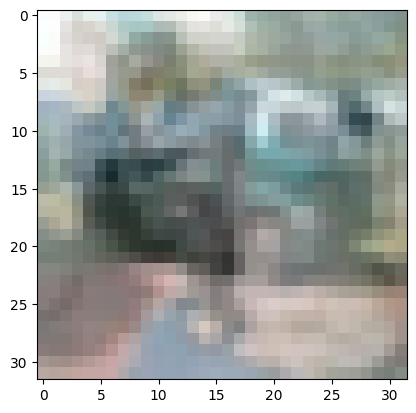

In [12]:
# Generate an example, display the image that the model will take as input, and print the categories of the two overlapping components
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
plt.imshow(x[0])

# Model Evaluation

Let us define first of all the test generator.

In [13]:
# Generate test samples for evaluation
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)
eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)
# Ensure the batch size matches your evaluation needs.

(10000, 32, 32, 3)


We now test a model producing random guesses. You will need to replace it with your own predictive model.

In [14]:
# Define the enhanced model with residual connections
def enhanced_model():
    input_layer = layers.Input(shape=(32, 32, 3))

    # Add Residual Connections
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv2D(64, (1, 1), padding='same')(input_layer) 
    x = layers.Add()([x, shortcut])
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    # Outputs
    output_1 = layers.Dense(5, activation='softmax', name='output_1')(x)
    output_2 = layers.Dense(5, activation='softmax', name='output_2')(x)

    model = Model(inputs=input_layer, outputs=[output_1, output_2])
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss={'output_1': 'categorical_crossentropy', 'output_2': 'categorical_crossentropy'},
        metrics={'output_1': ['accuracy'], 'output_2': ['accuracy']}
    )
    return model

# Instantiate the model
model = enhanced_model()

# Train the model using the generator
batch_size = 64
steps_per_epoch = 50000 // batch_size
validation_steps = 10000 // batch_size

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler with ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    datagenerator(cifar10_x_train_1, cifar10_x_train_2, cifar10_y_train_1, cifar10_y_train_2, batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=40,
    validation_data=datagenerator(cifar10_x_test_1, cifar10_x_test_2, cifar10_y_test_1, cifar10_y_test_2, batch_size),
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_scheduler]
)

2025-01-15 09:53:13.375790: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-15 09:53:13.376070: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-15 09:53:13.376534: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-15 09:53:13.376586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-15 09:53:13.377146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/40


2025-01-15 09:53:14.588383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


781/781 ━━━━━━━━━━━━━━━━━━━━ 69s 84ms/step - loss: 3.2615 - output_1_accuracy: 0.3588 - output_1_loss: 1.6818 - output_2_accuracy: 0.4007 - output_2_loss: 1.5797 - val_loss: 2.4756 - val_output_1_accuracy: 0.4685 - val_output_1_loss: 1.2790 - val_output_2_accuracy: 0.5302 - val_output_2_loss: 1.1966 - learning_rate: 3.0000e-04
Epoch 2/40
781/781 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - loss: 2.3827 - output_1_accuracy: 0.4683 - output_1_loss: 1.2904 - output_2_accuracy: 0.5665 - output_2_loss: 1.0922 - val_loss: 2.2044 - val_output_1_accuracy: 0.5130 - val_output_1_loss: 1.2085 - val_output_2_accuracy: 0.6086 - val_output_2_loss: 0.9958 - learning_rate: 3.0000e-04
Epoch 3/40
781/781 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - loss: 2.1546 - output_1_accuracy: 0.5136 - output_1_loss: 1.1937 - output_2_accuracy: 0.6297 - output_2_loss: 0.9609 - val_loss: 2.2941 - val_output_1_accuracy: 0.5163 - val_output_1_loss: 1.1764 - val_output_2_accuracy: 0.5583 - val_output_2_loss: 1.1177 - learning_rate: 3.

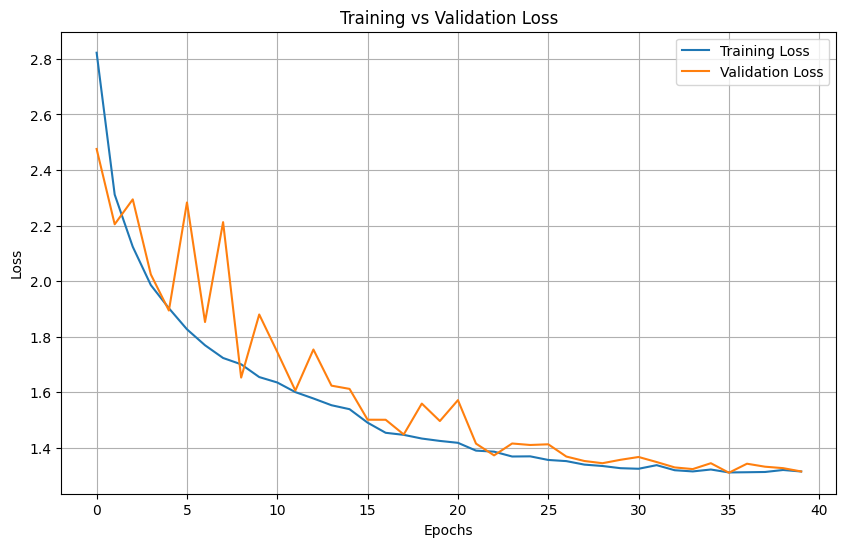

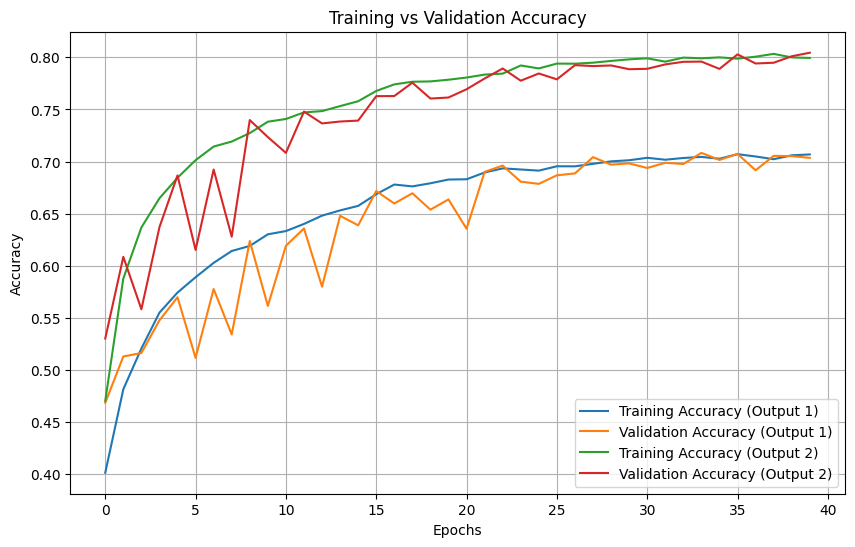

Epoch 1: Training Loss = 2.8220627307891846, Validation Loss = 2.475559949874878
Epoch 2: Training Loss = 2.3111870288848877, Validation Loss = 2.2043564319610596
Epoch 3: Training Loss = 2.1234378814697266, Validation Loss = 2.2940995693206787
Epoch 4: Training Loss = 1.9855427742004395, Validation Loss = 2.0238964557647705
Epoch 5: Training Loss = 1.9021090269088745, Validation Loss = 1.893861174583435
Epoch 6: Training Loss = 1.8263150453567505, Validation Loss = 2.2828526496887207
Epoch 7: Training Loss = 1.7688411474227905, Validation Loss = 1.8525768518447876
Epoch 8: Training Loss = 1.7230173349380493, Validation Loss = 2.212048053741455
Epoch 9: Training Loss = 1.700245976448059, Validation Loss = 1.6524124145507812
Epoch 10: Training Loss = 1.6543575525283813, Validation Loss = 1.8796240091323853
Epoch 11: Training Loss = 1.6347987651824951, Validation Loss = 1.74461030960083
Epoch 12: Training Loss = 1.600153923034668, Validation Loss = 1.6058567762374878
Epoch 13: Training L

In [15]:
# Retrieve loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
train_acc_1 = history.history['output_1_accuracy']
val_acc_1 = history.history['val_output_1_accuracy']
train_acc_2 = history.history['output_2_accuracy']
val_acc_2 = history.history['val_output_2_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc_1, label='Training Accuracy (Output 1)')
plt.plot(val_acc_1, label='Validation Accuracy (Output 1)')
plt.plot(train_acc_2, label='Training Accuracy (Output 2)')
plt.plot(val_acc_2, label='Validation Accuracy (Output 2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Print Training and Validation Loss per Epoch
for epoch, (train, val) in enumerate(zip(history.history['loss'], history.history['val_loss']), start=1):
    print(f"Epoch {epoch}: Training Loss = {train}, Validation Loss = {val}")


In [16]:
# Evaluation function for models
def eval_model(model):
    eval_samples_x, eval_samples_y = next(testgen)
    predictions = model.predict(eval_samples_x)
    # Extract predictions for both outputs
    pred_output_1 = np.argmax(predictions[0], axis=1)
    pred_output_2 = np.argmax(predictions[1], axis=1)
    
    # Calculate accuracy for both outputs
    correct_guesses_1 = pred_output_1 == np.argmax(eval_samples_y[0], axis=1)
    correct_guesses_2 = pred_output_2 == np.argmax(eval_samples_y[1], axis=1)

    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2

In [17]:
# Evaluate the model
average_accuracy = eval_model(model)
print(f"Average accuracy: {average_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Average accuracy: 0.748


As expected, the accuracy is around 1/5 = 0.2

Let us repeat the evaluation ten times, and compute the standard deviation

In [18]:
# Repeat the evaluation ten times, and compute the standard deviation
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
mean accuracy =  0.74881
standard deviation =  0.003390265476330736


In [19]:
# Save the model weights
model.save_weights('cifar10_model.weights.h5')

# What to Submit

As usual, you need to submit a single notebook that must be executable on Colab. The notebook should be properly commented and include a complete record of the training process, as well as the calculation of accuracy according to the guidelines provided above.

# Good luck!

